In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [2]:
pattern = r"""reading_speed=([^\s]+) B/s,parsing_speed=([^\s]+) B/s,size=([^\s]+) B,reading_milliseconds=([^,]+),parsing_milliseconds=([^,]+),PID=3992837,SLURM_JOB_ID=691720
Code block 'i=(\d+), fname='/scratch/shared/pwesolowski/mgr-pipeline/joined-cuml/([^.]+).json', count=\d+, force_host_read=([^,]+), pinned_read=([^,]+), cufile_params=(None|'cufile_thread_count=(\d+), cufile_slice_size_mb=(\d+)')' took: ([^\s]+) ms"""

In [3]:
measurements = []

with open("slurm-691720.out") as f:
    logs = f.read()

    for match in re.findall(pattern, logs, re.M):
        # We remove first "warmup" observation
        if (rep := int(match[5])) > 0:
            measurements.append({
                "reading_speed (GiB/sec)": float(match[0]) / 1024 / 1024 / 1024,
                "parsing_speed (GiB/sec)": float(match[1]) / 1024 / 1024 / 1024,
                "file_size (GiB)": float(match[2]) / 1024 / 1024 / 1024,
                "rep": rep,
                "file": match[6],
                "force_host_read": True if match[7] == "True" else False,
                "CPU memory type": "pinned memory" if match[8] == "True" else "regular memory" if match[8] == "False" else None,
                "number of\nIO threads": int(match[10]) if match[10] else None,
                "cufile_slice_size_mb": int(match[11]) if match[11] else None,
                "time (msecs)": float(match[12]),
                "lib": "mp"
            })
        
measurements_df = pd.DataFrame(measurements)

In [4]:
cudf_pattern = r"""Code block 'i=(\d+), fname='/scratch/shared/pwesolowski/mgr-pipeline/joined-cuml/([^.]+).json', os\.environ\['LIBCUDF_CUFILE_POLICY'\]='([^']+)', os\.environ\.get\('LIBCUDF_CUFILE_THREAD_COUNT'\)=([^,]+), os\.environ\.get\('LIBCUDF_CUFILE_SLICE_SIZE'\)=(.+)' took: ([^\s]+) ms
shape="""

measurements_cudf = []

with open("cudf-parser/slurm-707590.out") as f:
    logs = f.read()
    
    for match in re.findall(cudf_pattern, logs, re.M):
    # We remove first "warmup" observation
        if (rep := int(match[0])) > 0:
            measurements_cudf.append({
                "rep": rep,
                "file": match[1],
                "force_host_read": True if match[2] == "OFF" else False,
                "CPU memory type": "regular memory",
                "number of\nIO threads": int(match[3].strip("'")) if match[3] != 'None' else None,
                "cufile_slice_size_mb": int(match[4].strip("'")) if match[4] != 'None' else None,
                "time (msecs)": float(match[5]),
                "lib": "cudf"
            })
measurements_cudf_df = pd.DataFrame(measurements_cudf)

In [5]:
measurements_cudf_df["file_size (GiB)"] = measurements_cudf_df["file"].map(
    dict(measurements_df[["file", "file_size (GiB)"]].values)
)

In [6]:
full_measurements_df = pd.concat([measurements_df, measurements_cudf_df])

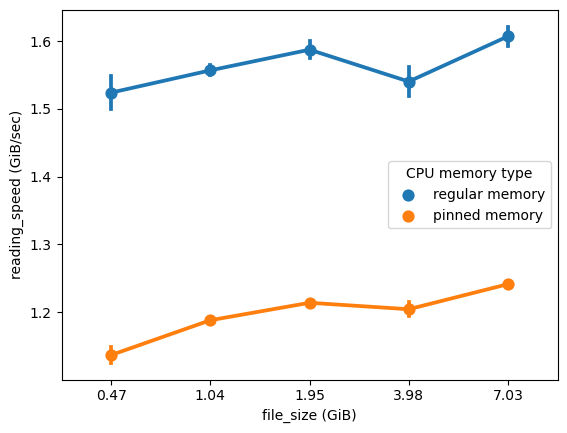

In [7]:
g = sns.pointplot(
    data=measurements_df[measurements_df["force_host_read"]],
    x="file_size (GiB)",
    y="reading_speed (GiB/sec)",
    hue="CPU memory type",
    palette=sns.color_palette(n_colors=2),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/pinned-read-reading-speed.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [8]:
measurements_cudf_df["force_host_read"]

0       True
1       True
2       True
3       True
4       True
       ...  
175    False
176    False
177    False
178    False
179    False
Name: force_host_read, Length: 180, dtype: bool

In [9]:
print(g)

Axes(0.125,0.11;0.775x0.77)


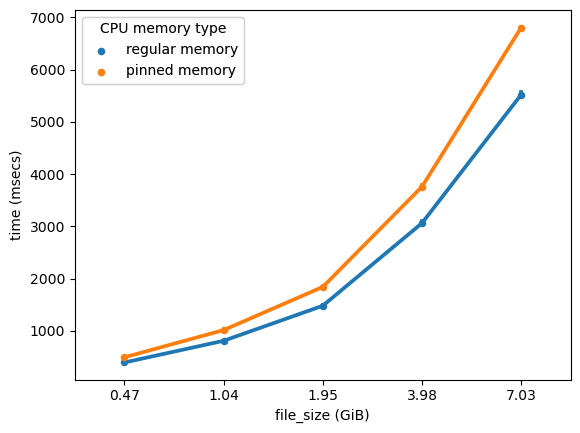

In [10]:
fig, ax = plt.subplots()
sns.pointplot(
    data=measurements_df[measurements_df["force_host_read"]],
    x="file_size (GiB)",
    y="time (msecs)",
    hue="CPU memory type",
    palette=sns.color_palette(n_colors=2),
    errorbar="se",
    ax=ax,
    linestyles="solid",
    markers=".",
#     color="lib"
)

# sns.pointplot(
#     data=measurements_cudf_df[measurements_cudf_df["force_host_read"]],
#     x="file_size (GiB)",
#     y="time (msecs)",
# #     hue="CPU memory type",

#     errorbar="se",
#     ax=ax,
#     linestyles="dotted",
#     markers=".",
#     color="k"
# #     color="lib"
# )




leg = ax.get_legend()
# ax.legend([l1, l2], ["metajsonparser", "cudf"], loc=4)
ax.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.gca().add_artist(leg)
plt.savefig(f"img/pinned-read-took.pdf", format="pdf", bbox_inches='tight')
plt.show()

Stąd decyzja, że odtąd używamy pinned_read = False

Uwaga! W eksperymentach ponizej wyszlo, ze cufile_slice_size_mb nie mial za duzego znaczenia (praktycznie zadne, wszystkie wykresy wygladaly z grubsza tak samo). Stąd zostajemy przy cufile_slice_size_mb = 1

In [11]:
pd.concat([measurements_df, measurements_cudf_df])

,reading_speed (GiB/sec),parsing_speed (GiB/sec),file_size (GiB),rep,file,force_host_read,CPU memory type,number of\nIO threads,cufile_slice_size_mb,time (msecs),lib
0,1.542619,1.269216,0.472118,1,West Virginia,True,regular memory,NaN,NaN,396.41714,mp
1,1.549989,1.262442,0.472118,2,West Virginia,True,regular memory,NaN,NaN,388.96203,mp
2,1.544512,1.263992,0.472118,3,West Virginia,True,regular memory,NaN,NaN,387.20936,mp
3,1.612423,1.308366,0.472118,4,West Virginia,True,regular memory,NaN,NaN,374.33369,mp
4,1.630919,1.332286,0.472118,5,West Virginia,True,regular memory,NaN,NaN,368.00696,mp
...,...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,1.949682,6,Alabama,False,regular memory,64.0,1048576.0,1265.67458,cudf
176,NaN,NaN,1.949682,7,Alabama,False,regular memory,64.0,1048576.0,1256.68930,cudf
177,NaN,NaN,1.949682,8,Alabama,False,regular memory,64.0,1048576.0,1039.09794,cudf
178,NaN,NaN,1.949682,9,Alabama,False,regular memory,64.0,1048576.0,1192.41289,cudf


In [12]:
measurements_cudf_df[~measurements_cudf_df["force_host_read"]]

,rep,file,force_host_read,CPU memory type,number of\nIO threads,cufile_slice_size_mb,time (msecs),lib,file_size (GiB)
30,1,West Virginia,False,regular memory,4.0,1048576.0,381.84232,cudf,0.472118
31,2,West Virginia,False,regular memory,4.0,1048576.0,390.39817,cudf,0.472118
32,3,West Virginia,False,regular memory,4.0,1048576.0,385.08687,cudf,0.472118
33,4,West Virginia,False,regular memory,4.0,1048576.0,382.02996,cudf,0.472118
34,5,West Virginia,False,regular memory,4.0,1048576.0,378.16718,cudf,0.472118
...,...,...,...,...,...,...,...,...,...
175,6,Alabama,False,regular memory,64.0,1048576.0,1265.67458,cudf,1.949682
176,7,Alabama,False,regular memory,64.0,1048576.0,1256.68930,cudf,1.949682
177,8,Alabama,False,regular memory,64.0,1048576.0,1039.09794,cudf,1.949682
178,9,Alabama,False,regular memory,64.0,1048576.0,1192.41289,cudf,1.949682


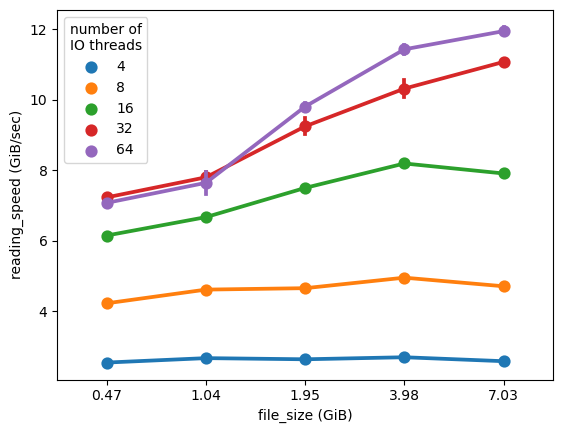

In [13]:
gds_df = measurements_df[
    (~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1)
]
g = sns.pointplot(
    data=gds_df,
    x="file_size (GiB)",
    y="reading_speed (GiB/sec)",
    hue=gds_df["number of\nIO threads"].astype(int),
    palette=sns.color_palette(n_colors=gds_df["number of\nIO threads"].nunique()),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/gds-reading-speed.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [14]:
from matplotlib.lines import Line2D

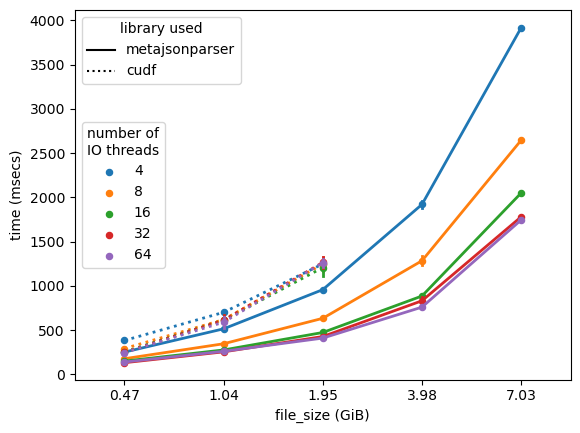

In [15]:
# sns.set(style="ticks", rc={"lines.linewidth": 1.5})
gds_df = measurements_df[
    (~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1)
]
gds_cudf_df = measurements_cudf_df[(~measurements_cudf_df["force_host_read"])]
fig, ax = plt.subplots()
sns.pointplot(
    data=gds_cudf_df,
    x="file_size (GiB)",
    y="time (msecs)",
    hue=gds_cudf_df["number of\nIO threads"].astype(int),
    palette=sns.color_palette(n_colors=gds_cudf_df["number of\nIO threads"].nunique()),
    errorbar="se",
    ax=ax,
    linestyles="dotted",
    markers="."
#     markers="+"
)
sns.pointplot(
    data=gds_df,
    x="file_size (GiB)",
    y="time (msecs)",
    hue=gds_df["number of\nIO threads"].astype(int),
    palette=sns.color_palette(n_colors=gds_df["number of\nIO threads"].nunique()),
    errorbar="se",
    ax=ax,
    linestyles="solid",
    markers="."
)

for l in ax.lines:
    plt.setp(l,linewidth=2)
    
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
legend1 = ax.legend(handout, lablout, title="number of\nIO threads", loc=6)

line_cudf = Line2D([0,1],[0,1],linestyle='dotted', color='black')
line_mp = Line2D([0,1],[0,1],linestyle='solid', color='black')
legend2 = ax.legend([line_mp, line_cudf], ["metajsonparser", "cudf"], title="library used", loc=0)
ax.add_artist(legend1)


ax.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/gds-took.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Comparison between GDS and non-GDS:

In [16]:
import numpy as np

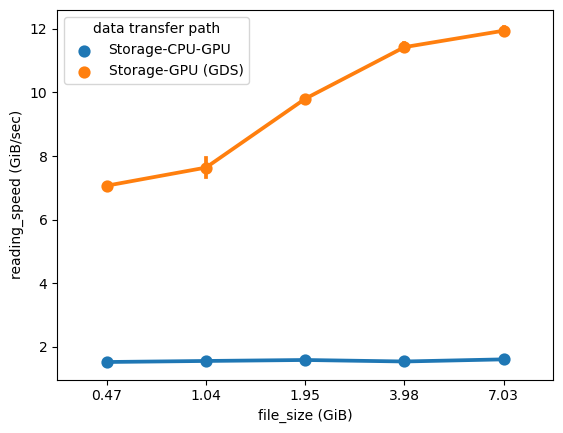

In [17]:
comparison_df = measurements_df.copy()[
    ((measurements_df["force_host_read"]) & (~(measurements_df["CPU memory type"].fillna("") == "pinned memory"))) |
    ((~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1) & (measurements_df["number of\nIO threads"] == 64))
]
# comparison_df["GDS"] = ~comparison_df["force_host_read"]
comparison_df["data transfer path"] = np.where(~comparison_df["force_host_read"], "Storage-GPU (GDS)", "Storage-CPU-GPU")
g = sns.pointplot(
    data=comparison_df,
    x="file_size (GiB)",
    y="reading_speed (GiB/sec)",
    hue="data transfer path",
    palette=sns.color_palette(n_colors=2),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/comparison-reading-speed.pdf", format="pdf", bbox_inches='tight')
plt.show()

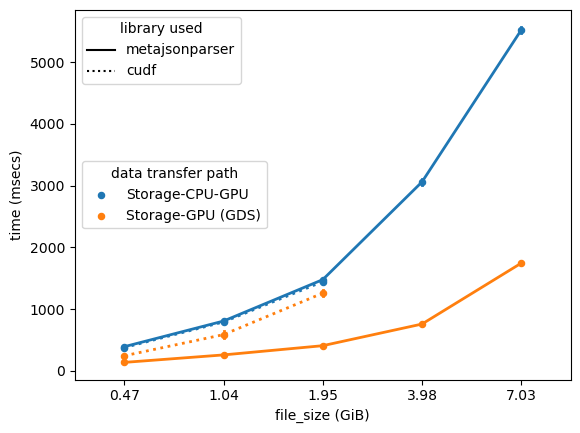

In [18]:
comparison_df = measurements_df.copy()[
    ((measurements_df["force_host_read"]) & (~(measurements_df["CPU memory type"].fillna("") == "pinned memory"))) |
    ((~measurements_df["force_host_read"]) & (measurements_df["cufile_slice_size_mb"] == 1) & (measurements_df["number of\nIO threads"] == 64))
]
comparison_cudf_df = measurements_cudf_df.copy()[
        (measurements_cudf_df["force_host_read"]) |
    (~measurements_cudf_df["force_host_read"]) & (measurements_cudf_df["number of\nIO threads"] == 64)
]
comparison_df["data transfer path"] = np.where(~comparison_df["force_host_read"], "Storage-GPU (GDS)", "Storage-CPU-GPU")
comparison_cudf_df["data transfer path"] = np.where(~comparison_cudf_df["force_host_read"], "Storage-GPU (GDS)", "Storage-CPU-GPU")

fig, ax = plt.subplots()
sns.pointplot(
    data=comparison_cudf_df,
    x="file_size (GiB)",
    y="time (msecs)",
    hue="data transfer path",
    palette=sns.color_palette(n_colors=2),
    errorbar="se",
    linestyles="dotted",
    markers="."
)
sns.pointplot(
    data=comparison_df,
    x="file_size (GiB)",
    y="time (msecs)",
    hue="data transfer path",
    palette=sns.color_palette(n_colors=2),
    errorbar="se",
    ax=ax,
    linestyles="solid",
    markers="."
)

for l in ax.lines:
    plt.setp(l,linewidth=2)
    
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
legend1 = ax.legend(handout, lablout, title="data transfer path", loc=6)

line_cudf = Line2D([0,1],[0,1],linestyle='dotted', color='black')
line_mp = Line2D([0,1],[0,1],linestyle='solid', color='black')
legend2 = ax.legend([line_mp, line_cudf], ["metajsonparser", "cudf"], title="library used", loc=0)
ax.add_artist(legend1)


ax.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/comparison-took.pdf", format="pdf", bbox_inches='tight')
plt.show()